In [1]:
import torch
from pathlib import Path
from pykeen.triples import TriplesFactory
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [9]:
model_dir = Path('C3_experiments/RotatE_d256_n5')  # <-- choose the model folder
model = torch.load(model_dir / 'trained_model.pkl', weights_only=False)
tf = TriplesFactory.from_path_binary(model_dir / 'training_triples')

entity_emb = model.entity_representations[0]().detach().cpu()
ent2id = tf.entity_to_id
id2ent = {v: k for k, v in ent2id.items()}

In [12]:
author_ids = [idx for ent, idx in ent2id.items() if isinstance(ent, str) and 'author' in ent]
author_labels = [id2ent[idx] for idx in author_ids]
author_vectors = entity_emb[author_ids]
author_vectors_np = author_vectors.detach().cpu().numpy() if hasattr(author_vectors, 'detach') else np.array(author_vectors)
author_vectors_real = np.concatenate([author_vectors_np.real, author_vectors_np.imag], axis=1)

Author Clustering

In [13]:
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(author_vectors_real)
    inertias.append(kmeans.inertia_)



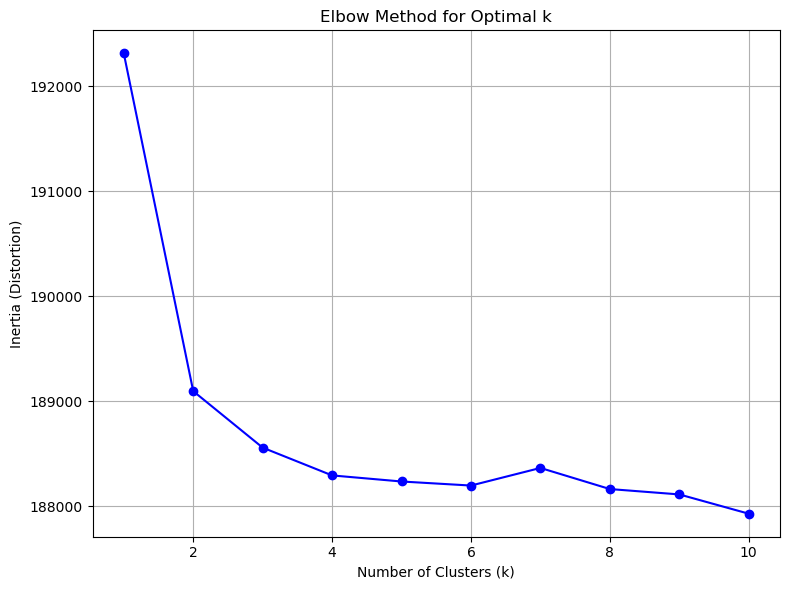

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Distortion)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.savefig('elbow_plot.png')
plt.show()

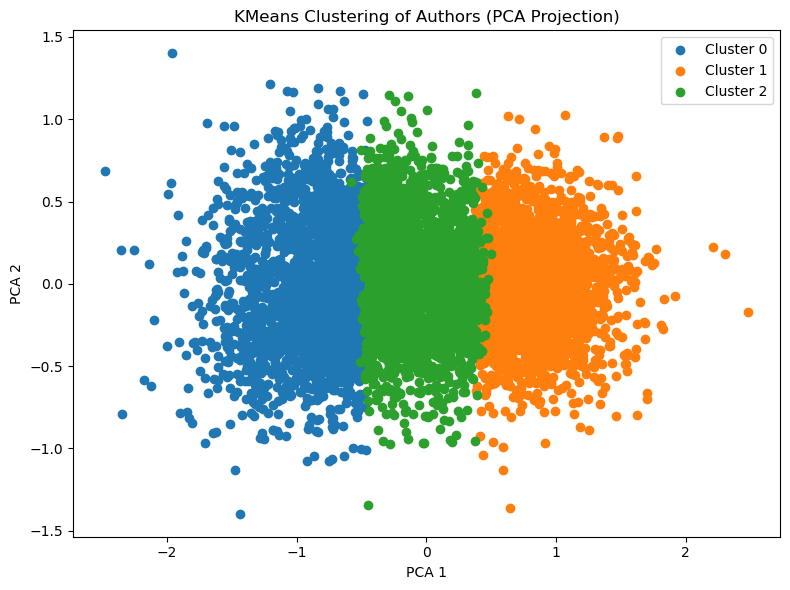

In [21]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(author_vectors_real)
pca = PCA(n_components=2)
reduced = pca.fit_transform(author_vectors_real)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(reduced[cluster_labels == i, 0],
                reduced[cluster_labels == i, 1],
                label=f'Cluster {i}')
plt.title('KMeans Clustering of Authors (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.tight_layout()
plt.savefig('author_clusters.png')
plt.show()

Anomaly Detection: Find the outliers of authors

In [23]:
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(author_vectors_real)
pred = clf.predict(author_vectors_real)
anomalies = [author_labels[i] for i, p in enumerate(pred) if p == -1]
print(f"Detected {len(anomalies)} anomalous authors:")
for a in anomalies:
    print(f" - {a}")

Detected 370 anomalous authors:
 - Nurse author & editor
 - http://example.org/research#author100555316
 - http://example.org/research#author100759722
 - http://example.org/research#author101087740
 - http://example.org/research#author101347210
 - http://example.org/research#author10167967
 - http://example.org/research#author101981808
 - http://example.org/research#author102239687
 - http://example.org/research#author10362010
 - http://example.org/research#author106474994
 - http://example.org/research#author107093541
 - http://example.org/research#author108521175
 - http://example.org/research#author111658864
 - http://example.org/research#author112728219
 - http://example.org/research#author112939148
 - http://example.org/research#author113795420
 - http://example.org/research#author114189193
 - http://example.org/research#author11445113
 - http://example.org/research#author114600036
 - http://example.org/research#author114851691
 - http://example.org/research#author114964900
 - htt

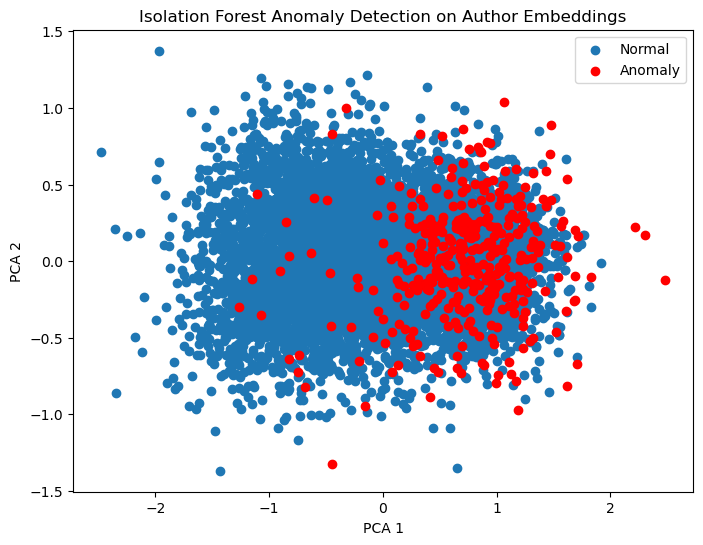

In [25]:

pca = PCA(n_components=2)
reduced = pca.fit_transform(author_vectors_real)

plt.figure(figsize=(8,6))
plt.scatter(reduced[pred == 1, 0], reduced[pred == 1, 1], label='Normal')
plt.scatter(reduced[pred == -1, 0], reduced[pred == -1, 1], label='Anomaly', color='red')
plt.legend()
plt.title("Isolation Forest Anomaly Detection on Author Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig('isolation_forest_anomaly_detection.png')
plt.show()

